In [1]:
from simulator.config import generate_cond
from sklearn.model_selection import train_test_split
from simulator.config import generate_every_world_configuration
from generate_passive_simulations import get_configuration_answer
from toddler.models import ValueNetwork
import torch
import numpy as np
from toddler.validate import validate
from tqdm import tqdm
import matplotlib.pyplot as plt
import pandas as pd
import glob

In [2]:
net_params = {"input_dim":10, "hidden_dim":40, "n_layers":4, "output_dim":6, "dropout":0.0}
value_network = ValueNetwork(**net_params).cuda()

In [3]:
every_conf = generate_every_world_configuration()
every_world_answer = np.array(list(map(get_configuration_answer, every_conf)))
n_configurations = len(every_conf)

train_size = 0.7
val_size = 0.15
test_size = 0.15

all_indices = np.arange(n_configurations)                                                     
train_indices, not_train_indices = train_test_split(all_indices, train_size=train_size,        
                                                    random_state=0, stratify=every_world_answer)
val_indices, test_indices = train_test_split(not_train_indices, train_size=0.5,
                                             random_state=0,                                  
                                             stratify=every_world_answer[not_train_indices])

In [4]:
TEST_EPISODES = 10
repeated_test_indices = np.random.choice(test_indices, TEST_EPISODES, replace=True)
test_cond = generate_cond(every_conf[repeated_test_indices])

In [5]:
model_list = glob.glob("*_model")
model_episodes = [int(model.split("_")[0]) for model in model_list]

sorted_model_list = sorted(zip(model_episodes, model_list))
model_episodes = sorted(model_episodes)

In [6]:
avg_length = []
accuracies = []

for _, model_path in tqdm(sorted_model_list):
    value_network.load_state_dict(torch.load(model_path))
    value_network.eval()
    valArgs = (value_network, {}, {}, test_cond, 1, 1, None, False)
    accuracy, trials = validate(*valArgs)
    
    lengths = [len(trial) for trial in trials]
    
    avg_length.append(np.mean(lengths))
    accuracies.append(accuracy)

  0%|          | 0/44 [00:00<?, ?it/s]/home/hector/Dissertation/diss/toddler/RecurrentWorker.py:82: RuntimeWarning: invalid value encountered in true_divide
  policy = np.array(policy) / sum(policy)
/home/hector/Dissertation/diss/toddler/RecurrentWorker.py:84: RuntimeWarning: invalid value encountered in less
  return np.random.choice(possibleActions, p=policy)
  2%|▏         | 1/44 [00:05<04:02,  5.65s/it]/home/hector/Dissertation/diss/toddler/RecurrentWorker.py:82: RuntimeWarning: invalid value encountered in true_divide
  policy = np.array(policy) / sum(policy)
/home/hector/Dissertation/diss/toddler/RecurrentWorker.py:84: RuntimeWarning: invalid value encountered in less
  return np.random.choice(possibleActions, p=policy)
100%|██████████| 44/44 [03:19<00:00,  3.12s/it]


In [7]:
d = {"episode": model_episodes, "accuracy": accuracies, "avg_length": avg_length}
df = pd.DataFrame.from_dict(d)
df.set_index("episode")

,accuracy,avg_length
episode,,
0,0.3,1304.1
1000,0.4,1231.6
2000,0.1,1640.5
3000,0.4,1227.0
4000,0.7,730.5
5000,0.7,631.5
6000,0.1,1660.5
7000,0.3,1326.9
8000,0.7,783.1


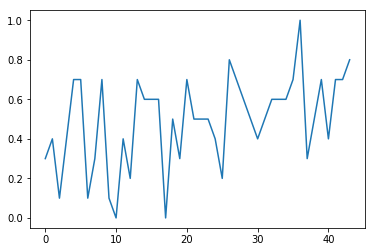

In [8]:
df.accuracy.plot()

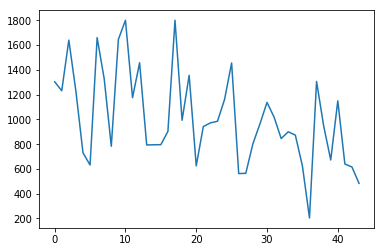

In [9]:
df.avg_length.plot()